# Mô hình phân loại genre trong phim ảnh

### Import các thư viện chính


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, hamming_loss, jaccard_score
import warnings
import matplotlib.cm as cm

file_path = 'movies_data_2.csv'

### Load data và làm sạch dữ liệu

In [2]:
# Function to load and clean data
def load_and_clean_data(file_path):
    print("Loading and cleaning data...")
    # Load data
    df = pd.read_csv(file_path)

    # Check for missing values
    print(f"Original data shape: {df.shape}")
    print(f"Missing values per column:\n{df.isnull().sum()}")

    # Drop rows with missing values in important columns
    df = df.dropna(subset=['description', 'genres', 'rating'])

    # Convert text columns to lowercase
    df['description'] = df['description'].str.lower()
    df['genres'] = df['genres'].str.lower()

    # Process genres
    df['genres_list'] = df['genres'].apply(lambda x: [genre.strip() for genre in x.split(',')])

    # Remove duplicates
    duplicates_before = df.shape[0]
    df = df.drop_duplicates(subset=['title', 'description'])
    duplicates_removed = duplicates_before - df.shape[0]

    print(f"Rows removed due to missing values: {duplicates_before - df.shape[0]}")
    print(f"Rows removed due to duplicates: {duplicates_removed}")
    print(f"Cleaned data shape: {df.shape}")

    return df


df = load_and_clean_data(file_path)

Loading and cleaning data...
Original data shape: (1957, 7)
Missing values per column:
id                0
title             0
description       3
genres            0
genre_category    0
rating            0
url               0
dtype: int64
Rows removed due to missing values: 602
Rows removed due to duplicates: 602
Cleaned data shape: (1352, 8)


### Trực quan hóa dữ liệu đầu vào

Visualizing genre distribution...


<ipython-input-3-720917800718>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')


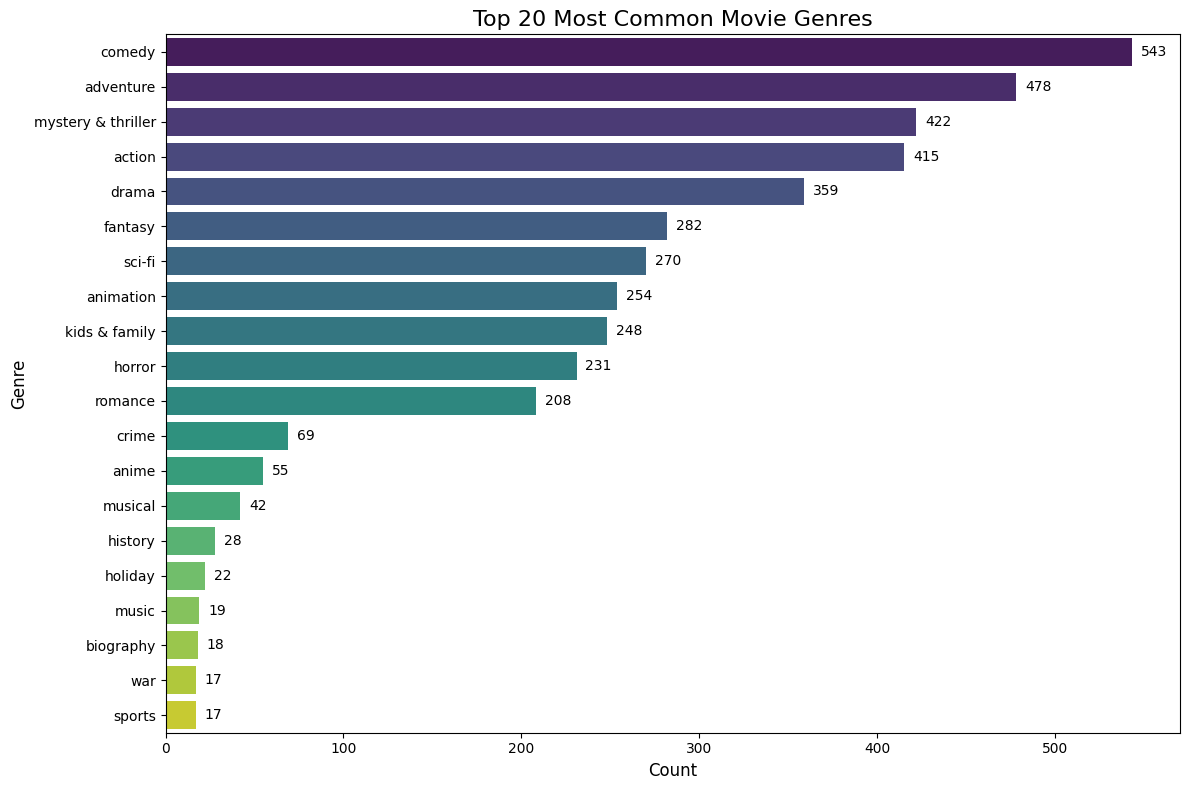

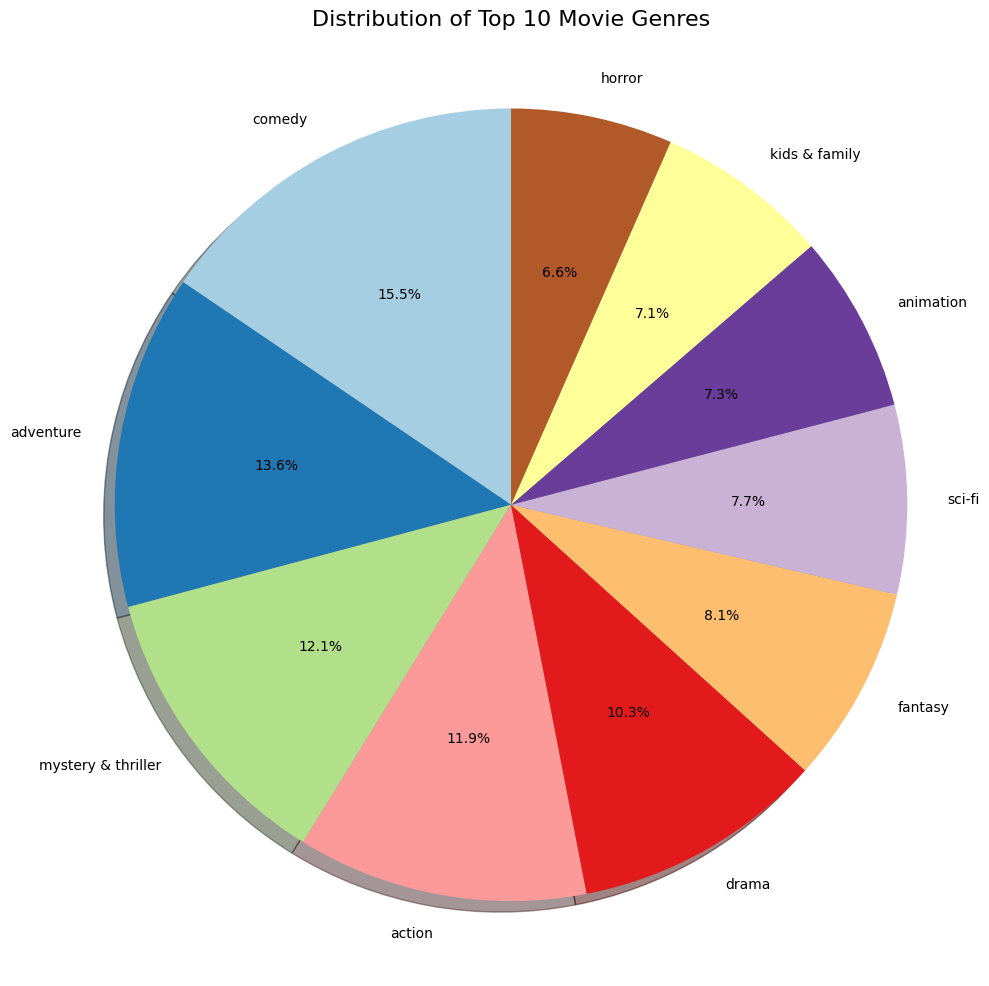

In [3]:
def visualize_genre_distribution(df):
    print("Visualizing genre distribution...")

    # Explode the genres_list column to get one row per genre
    genre_df = df.explode('genres_list')

    # Count occurrences of each genre
    genre_counts = genre_df['genres_list'].value_counts().reset_index()
    genre_counts.columns = ['genre', 'count']

    # Get top 20 genres
    top_genres = genre_counts.head(20)

    # Create barplot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')

    # Add count labels to the bars
    for i, count in enumerate(top_genres['count']):
        ax.text(count + 5, i, str(count), va='center')

    plt.title('Top 20 Most Common Movie Genres', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    plt.tight_layout()
    plt.show()  # Hiển thị bar chart

    # Create a pie chart for top 10 genres
    plt.figure(figsize=(10, 10))
    top10 = genre_counts.head(10)
    plt.pie(top10['count'], labels=top10['genre'], autopct='%1.1f%%',
            shadow=True, startangle=90, colors=plt.cm.Paired(np.linspace(0, 1, 10)))
    plt.axis('equal')
    plt.title('Distribution of Top 10 Movie Genres', fontsize=16)
    plt.tight_layout()
    plt.show()  # Hiển thị pie chart

visualize_genre_distribution(df)

Visualizing rating distribution...


<ipython-input-4-97be7b675b3f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='rating', y='count', data=rating_counts, palette='rocket')


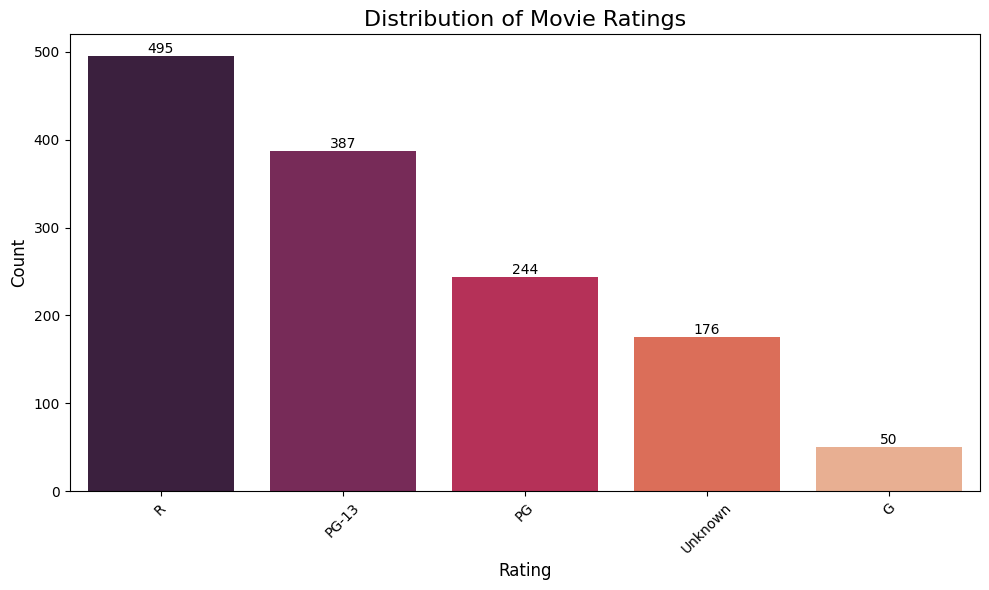

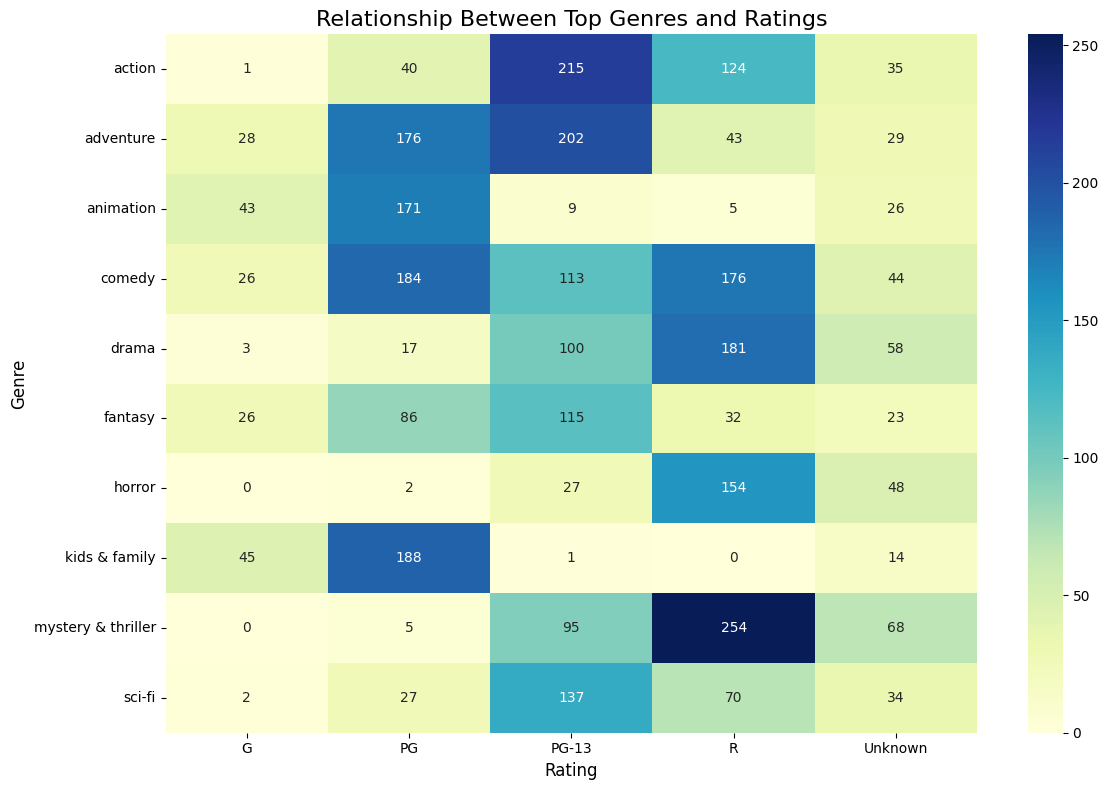

In [4]:
# Function to visualize rating distribution
def visualize_rating_distribution(df):
    print("Visualizing rating distribution...")

    # Count occurrences of each rating
    rating_counts = df['rating'].value_counts().reset_index()
    rating_counts.columns = ['rating', 'count']

    # Create barplot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='rating', y='count', data=rating_counts, palette='rocket')

    # Add count labels to the bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'bottom', fontsize=10)

    plt.title('Distribution of Movie Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

    # Create a heatmap of ratings vs. top genres
    genre_df = df.explode('genres_list')
    top_genres = genre_df['genres_list'].value_counts().head(10).index

    # Filter for top genres
    genre_df = genre_df[genre_df['genres_list'].isin(top_genres)]

    # Create a crosstab
    cross_tab = pd.crosstab(genre_df['genres_list'], genre_df['rating'])

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d')
    plt.title('Relationship Between Top Genres and Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

visualize_rating_distribution(df)

### Extract features

In [6]:
def extract_features(df):
    print("Extracting features...")
    # Create feature dataframe
    X = df[['description', 'rating']]

    # Use MultiLabelBinarizer to convert genres list to binary matrix
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['genres_list'])

    # Get the genre names
    genre_names = mlb.classes_
    print(f"Total number of unique genres: {len(genre_names)}")
    print(f"Some example genres: {genre_names[:10]}")

    return X, y, mlb

X, y, mlb = extract_features(df)

Extracting features...
Total number of unique genres: 25
Some example genres: ['action' 'adventure' 'animation' 'anime' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy']


### Xủ lí và chuẩn hóa dữ liệu

Train set size: 946
Validation set size: 203
Test set size: 203
Processing features...
Processing features...
Visualizing feature extraction...


<ipython-input-7-db929258609d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='feature', y='importance', data=tfidf_df, palette='cool')


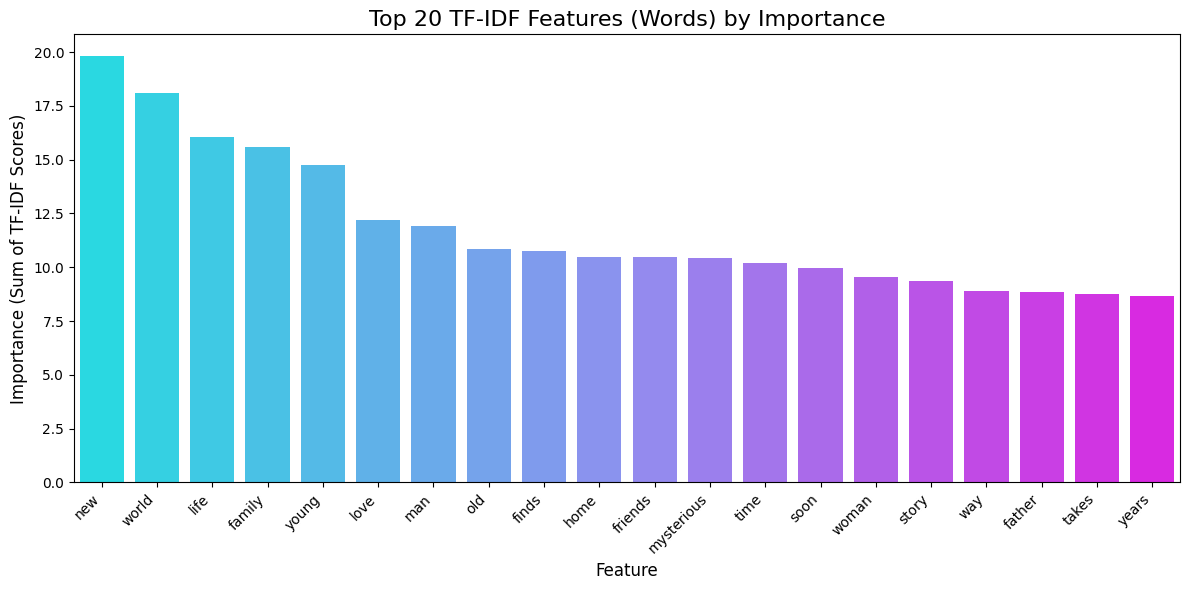

<ipython-input-7-db929258609d>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Rating', y='Encoded Value', data=rating_df, palette='rocket')


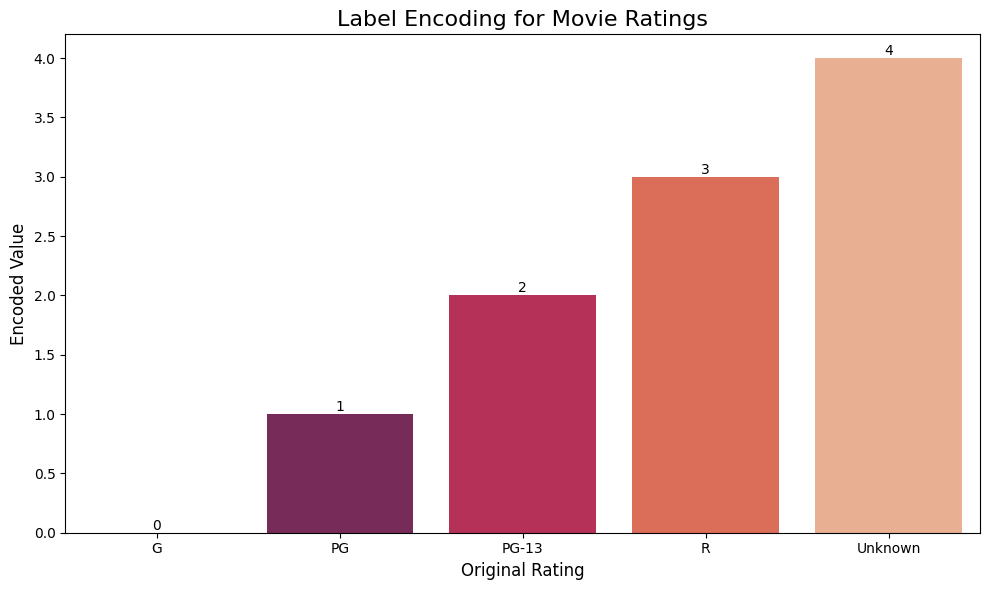

In [7]:
def visualize_feature_extraction(tfidf, X_train_processed, le):
    print("Visualizing feature extraction...")

    # Get feature names from TF-IDF
    feature_names = tfidf.get_feature_names_out()

    # Get top 20 TF-IDF features by weight across the corpus
    tfidf_sum = np.sum(X_train_processed[:, :len(feature_names)], axis=0)
    top_indices = tfidf_sum.argsort()[-20:][::-1]
    top_values = tfidf_sum[top_indices]
    top_features = [feature_names[i] for i in top_indices]

    # Create DataFrame for visualization
    tfidf_df = pd.DataFrame({'feature': top_features, 'importance': top_values})

    # Create barplot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='feature', y='importance', data=tfidf_df, palette='cool')
    plt.title('Top 20 TF-IDF Features (Words) by Importance', fontsize=16)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Importance (Sum of TF-IDF Scores)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Visualize encoding for ratings
    if hasattr(le, 'classes_'):
        # Create a mapping of original values to encoded values
        rating_mapping = {original: encoded for original, encoded in zip(le.classes_, range(len(le.classes_)))}

        # Create DataFrame for visualization
        rating_df = pd.DataFrame(list(rating_mapping.items()), columns=['Rating', 'Encoded Value'])

        # Create a visualization of the encoding
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Rating', y='Encoded Value', data=rating_df, palette='rocket')

        # Add labels
        for i, p in enumerate(ax.patches):
            ax.annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'bottom', fontsize=10)

        plt.title('Label Encoding for Movie Ratings', fontsize=16)
        plt.xlabel('Original Rating', fontsize=12)
        plt.ylabel('Encoded Value', fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.close()

def process_features(X_train, X_test):
    print("Processing features...")
    # TF-IDF for description with n-grams for better text representation
    tfidf = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),  # Include unigrams and bigrams
        min_df=3,  # Minimum document frequency
        max_df=0.9  # Maximum document frequency
    )
    X_train_description = tfidf.fit_transform(X_train['description'])
    X_test_description = tfidf.transform(X_test['description'])

    # Label Encoding for ratings
    le = LabelEncoder()
    X_train_rating = le.fit_transform(X_train['rating']).reshape(-1, 1)
    X_test_rating = le.transform(X_test['rating']).reshape(-1, 1)

    # Convert sparse matrix to dense for description
    X_train_description_dense = X_train_description.toarray()
    X_test_description_dense = X_test_description.toarray()

    # Combine features
    X_train_processed = np.hstack((X_train_description_dense, X_train_rating))
    X_test_processed = np.hstack((X_test_description_dense, X_test_rating))

    # Visualize feature extraction


    return X_train_processed, X_test_processed, tfidf, le

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Process features
X_train_processed, X_val_processed, tfidf, le = process_features(X_train, X_val)
_, X_test_processed, _, _ = process_features(X_train, X_test)
visualize_feature_extraction(tfidf, X_train_processed, le)


### Giảm chiều dữ liệu

Reducing dimensions...
Explained variance with 100 components: 0.65
Visualizing dimension reduction...


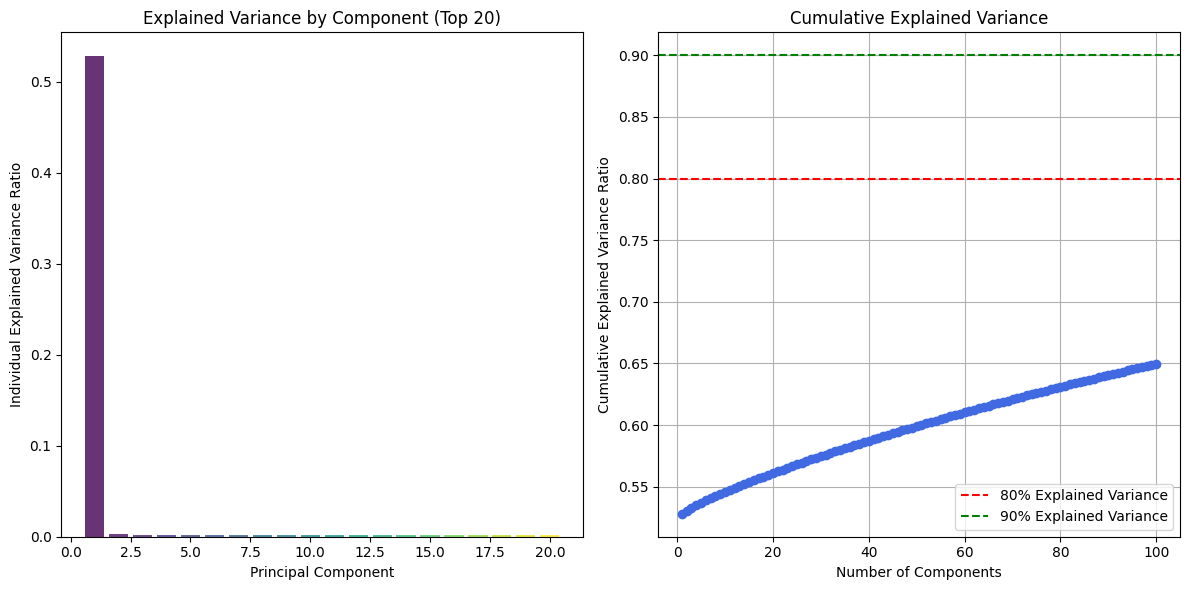

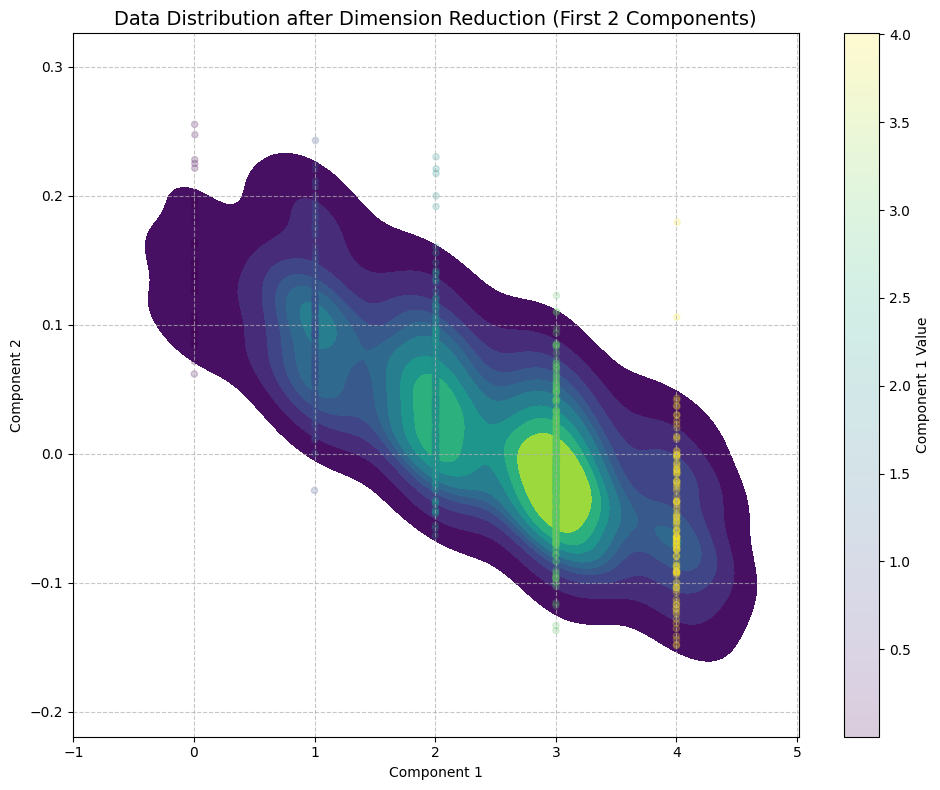

In [8]:
def visualize_dimension_reduction(svd, X_reduced):
    print("Visualizing dimension reduction...")

    # Plot explained variance by components
    explained_var = svd.explained_variance_ratio_
    cum_explained_var = np.cumsum(explained_var)

    # Create plot
    plt.figure(figsize=(12, 6))
    components = range(1, len(explained_var) + 1)

    # Bar chart for individual explained variance
    ax1 = plt.subplot(1, 2, 1)
    ax1.bar(components[:20], explained_var[:20], alpha=0.8, color=plt.cm.viridis(np.linspace(0, 1, 20)))
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Individual Explained Variance Ratio')
    ax1.set_title('Explained Variance by Component (Top 20)')

    # Line chart for cumulative explained variance
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(components, cum_explained_var, marker='o', linestyle='-', color='royalblue')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance')
    ax2.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
    ax2.axhline(y=0.9, color='g', linestyle='--', label='90% Explained Variance')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

    # Visualize the first two components as a scatter plot with density
    plt.figure(figsize=(10, 8))

    # Create a scatter plot
    sns.kdeplot(x=X_reduced[:, 0], y=X_reduced[:, 1],
               cmap="viridis", fill=True, thresh=0.05)

    plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
               s=20, c=X_reduced[:, 0], cmap="viridis", alpha=0.2)

    plt.colorbar(label='Component 1 Value')
    plt.title('Data Distribution after Dimension Reduction (First 2 Components)', fontsize=14)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    plt.close()

def reduce_dimensions(X_train, X_test, n_components=100):
    print("Reducing dimensions...")
    # Apply Truncated SVD
    svd = TruncatedSVD(n_components=n_components)
    X_train_reduced = svd.fit_transform(X_train)
    X_test_reduced = svd.transform(X_test)

    # Apply MinMaxScaler to ensure non-negative values for Logistic Regression
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_reduced)
    X_test_scaled = scaler.transform(X_test_reduced)

    # Explained variance
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"Explained variance with {n_components} components: {explained_variance:.2f}")

    # Visualize the dimension reduction
    visualize_dimension_reduction(svd, X_train_reduced)

    return X_train_scaled, X_test_scaled, svd, scaler

n_components = min(100, min(X_train_processed.shape[0], X_train_processed.shape[1]) - 1)
X_train_reduced, X_val_reduced, svd, scaler = reduce_dimensions(X_train_processed, X_val_processed, n_components)
X_test_reduced = svd.transform(X_test_processed)
X_test_reduced = scaler.transform(X_test_reduced)

Trực quan hóa dữ liệu train

Visualizing data...


<ipython-input-9-fc2e8f187c43>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_genres))


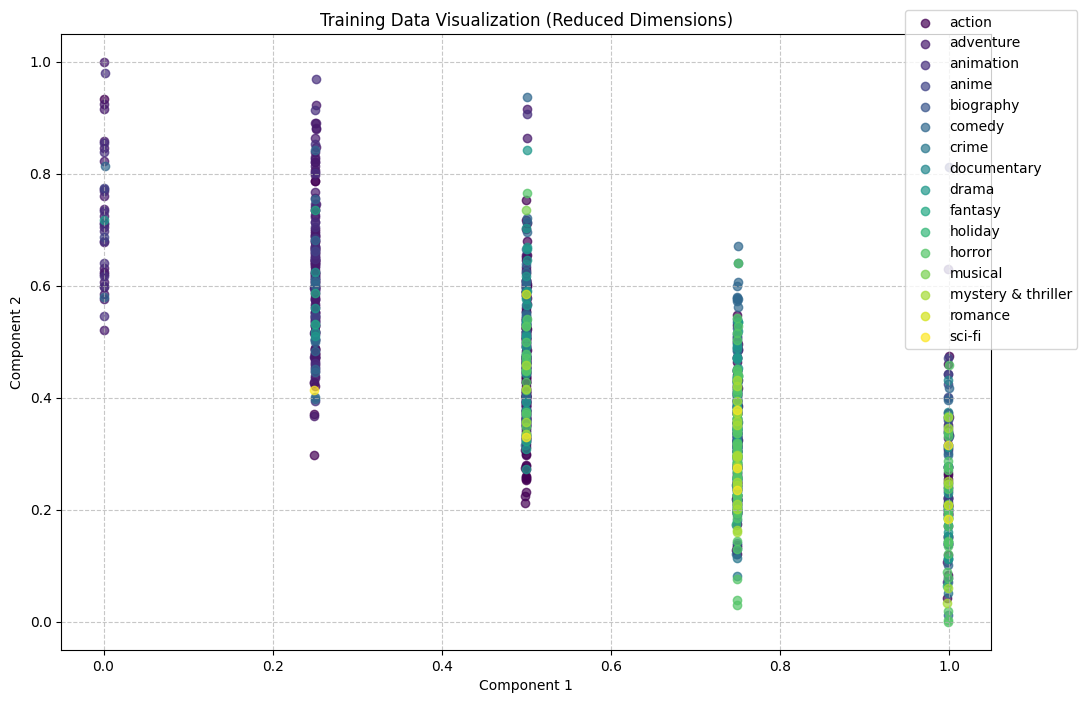

In [9]:
def visualize_data(X_reduced, y, mlb, title="Dimensionality Reduction Visualization"):
    print("Visualizing data...")
    # Create a 2D plot using the first two components
    plt.figure(figsize=(12, 8))

    # Since we have multi-label data, we'll color points based on the most frequent genre
    # For each sample, find the index of the genre with value 1
    genre_indices = [np.where(sample == 1)[0] for sample in y]

    # Choose the first genre for each sample (if available)
    chosen_genres = [indices[0] if len(indices) > 0 else -1 for indices in genre_indices]

    # Get unique genre indices
    unique_genres = np.unique(chosen_genres)

    # Define a colormap
    cmap = plt.cm.get_cmap('viridis', len(unique_genres))

    # Plot each genre
    for i, genre_idx in enumerate(unique_genres):
        if genre_idx == -1:
            continue  # Skip samples with no genres

        mask = np.array(chosen_genres) == genre_idx
        plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1],
                   color=cmap(i), label=mlb.classes_[genre_idx] if genre_idx >= 0 else 'Unknown',
                   alpha=0.7)

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    plt.close()

visualize_data(X_train_reduced, y_train, mlb, "Training Data Visualization (Reduced Dimensions)")

### Train mô hình phân loại thể loại của chương trình

In [10]:
def predict_with_adjusted_threshold(model, X, threshold=0.15):
    """
    Predict with lowered threshold focusing on getting at least 1 out of 3 genres correct
    """
    # Get probabilities for each genre
    probs = []
    for estimator in model.estimators_:
        if hasattr(estimator, 'predict_proba'):
            probs.append(estimator.predict_proba(X)[:, 1])

    probs = np.array(probs).T  # Shape: [n_samples, n_labels]

    # Create initial prediction matrix with threshold
    y_pred = (probs >= threshold).astype(int)

    # For each sample, ensure exactly 3 genres are predicted
    for i in range(y_pred.shape[0]):
        # Count predicted genres
        n_predicted = np.sum(y_pred[i])

        if n_predicted == 3:
            # Already at 3 genres - keep as is
            continue
        elif n_predicted < 3:
            # Need to add more genres
            # Find indices of zeros (unpredicted genres)
            zero_indices = np.where(y_pred[i] == 0)[0]
            # Sort by probability
            sorted_indices = sorted([(idx, probs[i, idx]) for idx in zero_indices],
                                   key=lambda x: x[1], reverse=True)
            # Add top genres to reach 3
            to_add = 3 - n_predicted
            for j in range(min(to_add, len(sorted_indices))):
                y_pred[i, sorted_indices[j][0]] = 1
        else:
            # Too many genres predicted - keep only top 3
            # Get all predicted genre indices
            pred_indices = np.where(y_pred[i] == 1)[0]
            # Sort by probability
            sorted_indices = sorted([(idx, probs[i, idx]) for idx in pred_indices],
                                   key=lambda x: x[1], reverse=True)
            # Reset predictions
            y_pred[i] = 0
            # Keep top 3
            for j in range(min(3, len(sorted_indices))):
                y_pred[i, sorted_indices[j][0]] = 1

    return y_pred, probs

def accuracy(y_true, y_pred):
    """
    Calculate partial accuracy - percentage of samples that have at least one genre predicted correctly

    Args:
        y_true: Matrix of true genre labels (one-hot encoded)
        y_pred: Matrix of predicted genre labels (one-hot encoded)

    Returns:
        Partial accuracy score (0.0 to 1.0)
    """
    correct_count = 0
    total_samples = y_true.shape[0]

    for i in range(total_samples):
        # Get true and predicted genres
        true_genres = set(np.where(y_true[i] == 1)[0])
        pred_genres = set(np.where(y_pred[i] == 1)[0])

        # Check if at least one genre is correctly predicted
        if len(true_genres.intersection(pred_genres)) > 0:
            correct_count += 1

    return correct_count / total_samples if total_samples > 0 else 0

def train_models(X_train, y_train, X_val, y_val, mlb):
    print("Training models...")

    # Multi-label models with Logistic Regression
    print("Training Logistic Regression model...")
    lr_model = MultiOutputClassifier(LogisticRegression(max_iter=1000, C=1.0, solver='liblinear'))
    lr_model.fit(X_train, y_train)

    # Predict with adjusted threshold
    lr_val_pred, lr_val_probs = predict_with_adjusted_threshold(lr_model, X_val, threshold=0.15)

    # Evaluate metrics
    lr_val_jaccard = jaccard_score(y_val, lr_val_pred, average='samples')
    lr_val_hamming = hamming_loss(y_val, lr_val_pred)
    lr_val_partial_acc = accuracy(y_val, lr_val_pred)

    print(f"Logistic Regression Validation Jaccard Score: {lr_val_jaccard:.4f}")
    print(f"Logistic Regression Validation Hamming Loss: {lr_val_hamming:.4f}")
    print(f"Logistic Regression Validation Partial Accuracy: {lr_val_partial_acc:.4f}")

    # Try with C=2.0 for Logistic Regression
    lr_c2_model = MultiOutputClassifier(LogisticRegression(max_iter=1000, C=2.0, solver='liblinear'))
    lr_c2_model.fit(X_train, y_train)
    lr_c2_val_pred, lr_c2_val_probs = predict_with_adjusted_threshold(lr_c2_model, X_val, threshold=0.12)
    lr_c2_val_jaccard = jaccard_score(y_val, lr_c2_val_pred, average='samples')
    lr_c2_val_hamming = hamming_loss(y_val, lr_c2_val_pred)
    lr_c2_val_partial_acc = accuracy(y_val, lr_c2_val_pred)

    print(f"LR (C=2.0) Validation Jaccard Score: {lr_c2_val_jaccard:.4f}")
    print(f"LR (C=2.0) Validation Hamming Loss: {lr_c2_val_hamming:.4f}")
    print(f"LR (C=2.0) Validation Partial Accuracy: {lr_c2_val_partial_acc:.4f}")

    # Multi-label models with SVM
    print("Training SVM model...")
    svm_model = MultiOutputClassifier(SVC(kernel='linear', probability=True, C=1.0))
    svm_model.fit(X_train, y_train)

    # Predict with adjusted threshold
    svm_val_pred, svm_val_probs = predict_with_adjusted_threshold(svm_model, X_val, threshold=0.15)

    # Evaluate metrics
    svm_val_jaccard = jaccard_score(y_val, svm_val_pred, average='samples')
    svm_val_hamming = hamming_loss(y_val, svm_val_pred)
    svm_val_partial_acc = accuracy(y_val, svm_val_pred)

    print(f"SVM Validation Jaccard Score: {svm_val_jaccard:.4f}")
    print(f"SVM Validation Hamming Loss: {svm_val_hamming:.4f}")
    print(f"SVM Validation Partial Accuracy: {svm_val_partial_acc:.4f}")

    return {
        'logistic_regression': {
            'model': lr_model,
            'jaccard': lr_val_jaccard,
            'hamming_loss': lr_val_hamming,
            'partial_accuracy': lr_val_partial_acc,
            'predictions': lr_val_pred,
            'probabilities': lr_val_probs
        },
        'logistic_regression_c2': {
            'model': lr_c2_model,
            'jaccard': lr_c2_val_jaccard,
            'hamming_loss': lr_c2_val_hamming,
            'partial_accuracy': lr_c2_val_partial_acc,
            'predictions': lr_c2_val_pred,
            'probabilities': lr_c2_val_probs
        },
        'svm': {
            'model': svm_model,
            'jaccard': svm_val_jaccard,
            'hamming_loss': svm_val_hamming,
            'partial_accuracy': svm_val_partial_acc,
            'predictions': svm_val_pred,
            'probabilities': svm_val_probs
        }
    }

models = train_models(X_train_reduced, y_train, X_val_reduced, y_val, mlb)

Training models...
Training Logistic Regression model...
Logistic Regression Validation Jaccard Score: 0.4486
Logistic Regression Validation Hamming Loss: 0.0985
Logistic Regression Validation Partial Accuracy: 0.9409
LR (C=2.0) Validation Jaccard Score: 0.4618
LR (C=2.0) Validation Hamming Loss: 0.0962
LR (C=2.0) Validation Partial Accuracy: 0.9310
Training SVM model...
SVM Validation Jaccard Score: 0.4575
SVM Validation Hamming Loss: 0.0973
SVM Validation Partial Accuracy: 0.9261


### Đánh giá mô hình

Evaluating models...
LOGISTIC_REGRESSION Test Jaccard Score: 0.4459
LOGISTIC_REGRESSION Test Hamming Loss: 0.0995
LOGISTIC_REGRESSION Test Partial Accuracy (≥1 correct in 3): 0.9360

Classification Report for Top 5 Most Common Genres (LOGISTIC_REGRESSION):

Genre: mystery & thriller
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       144
           1       0.48      0.83      0.60        59

    accuracy                           0.68       203
   macro avg       0.69      0.73      0.67       203
weighted avg       0.78      0.68      0.70       203


Genre: drama
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       144
           1       0.41      0.58      0.48        59

    accuracy                           0.64       203
   macro avg       0.60      0.62      0.60       203
weighted avg       0.68      0.64      0.65       203


Genre: action
              precision    recall

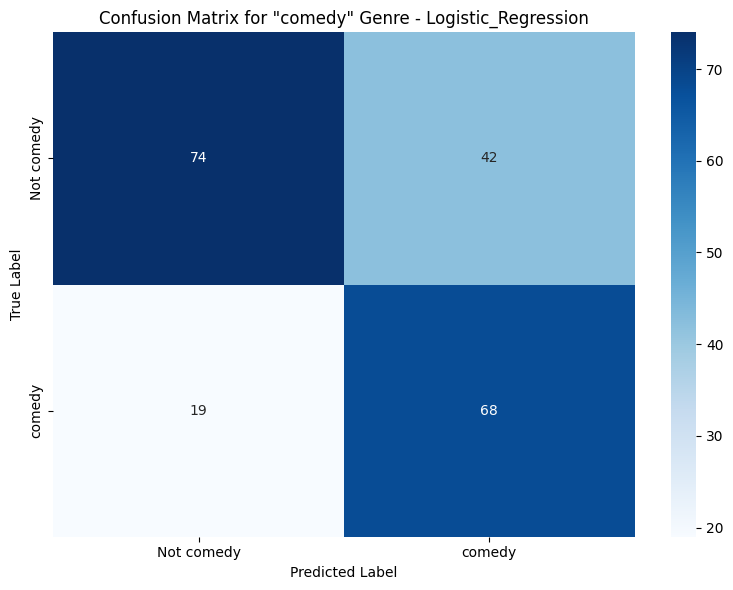

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


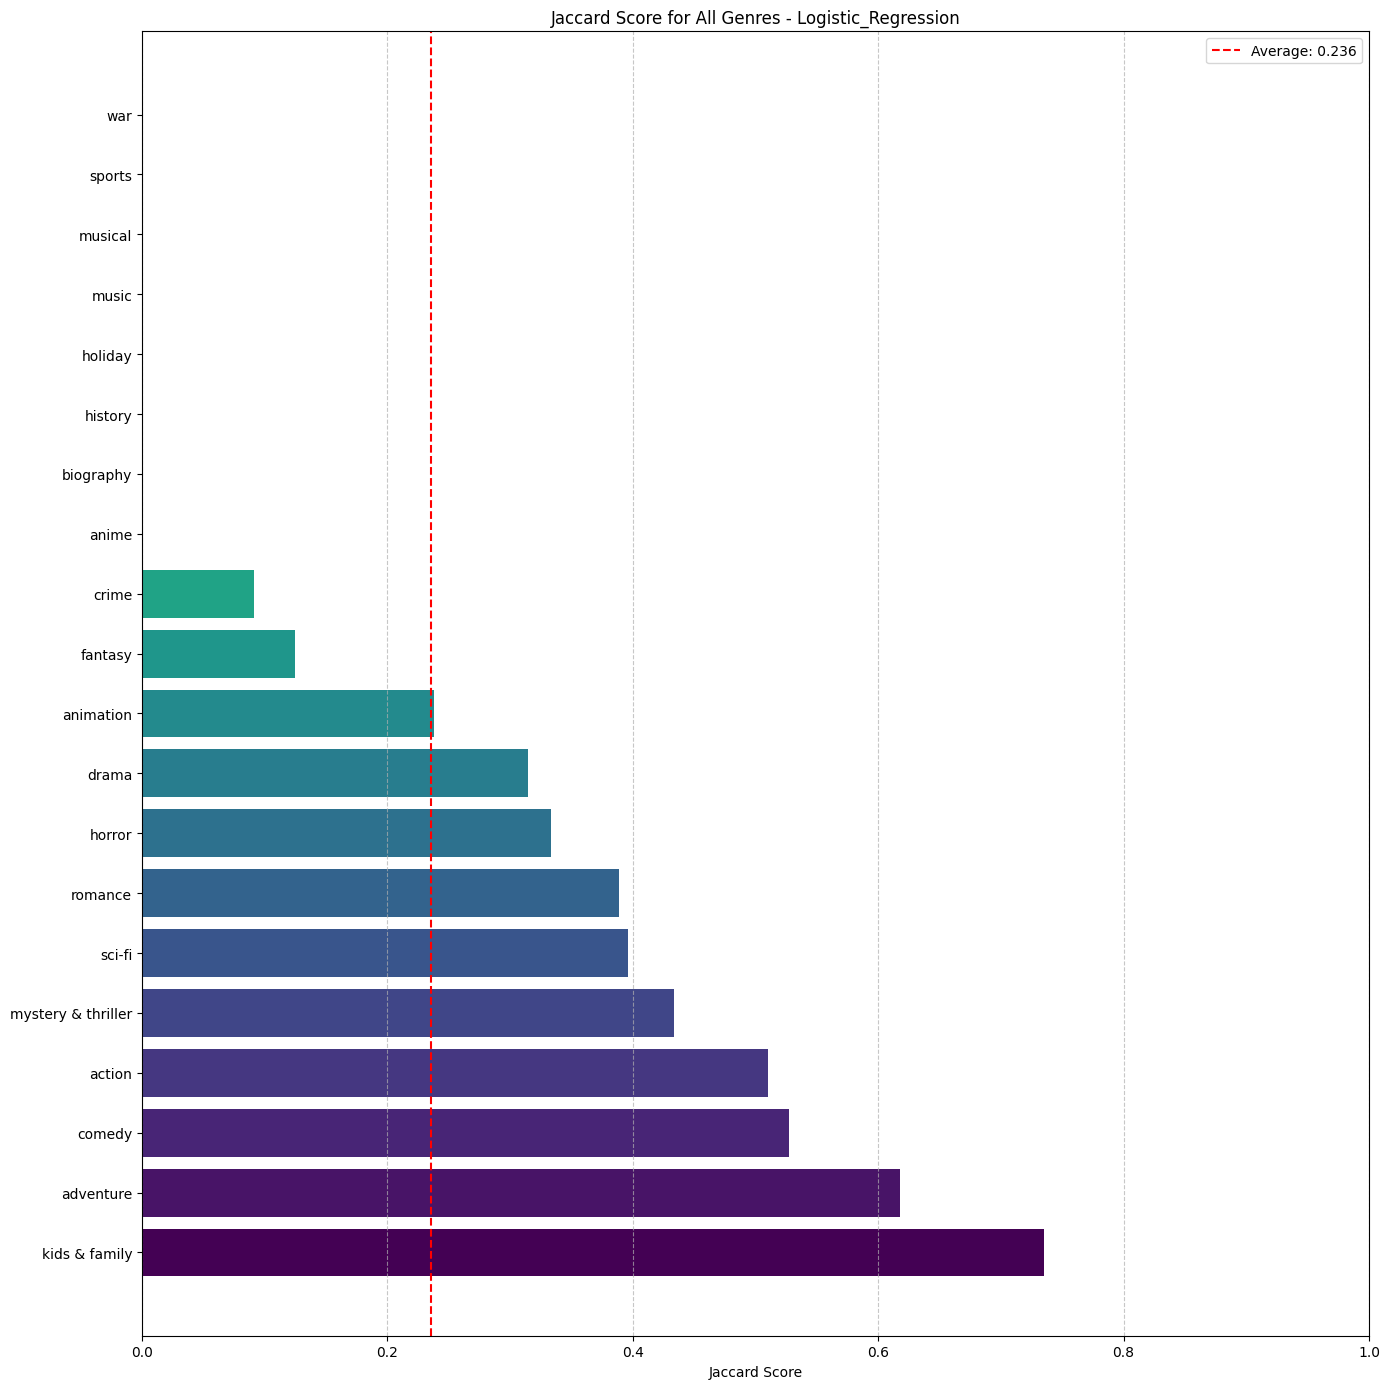

LOGISTIC_REGRESSION_C2 Test Jaccard Score: 0.4523
LOGISTIC_REGRESSION_C2 Test Hamming Loss: 0.0983
LOGISTIC_REGRESSION_C2 Test Partial Accuracy (≥1 correct in 3): 0.9360

Classification Report for Top 5 Most Common Genres (LOGISTIC_REGRESSION_C2):

Genre: mystery & thriller
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       144
           1       0.50      0.86      0.63        59

    accuracy                           0.70       203
   macro avg       0.71      0.75      0.69       203
weighted avg       0.80      0.70      0.72       203


Genre: drama
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       144
           1       0.41      0.56      0.47        59

    accuracy                           0.64       203
   macro avg       0.60      0.61      0.60       203
weighted avg       0.68      0.64      0.65       203


Genre: action
              precision    recall  f1-scor

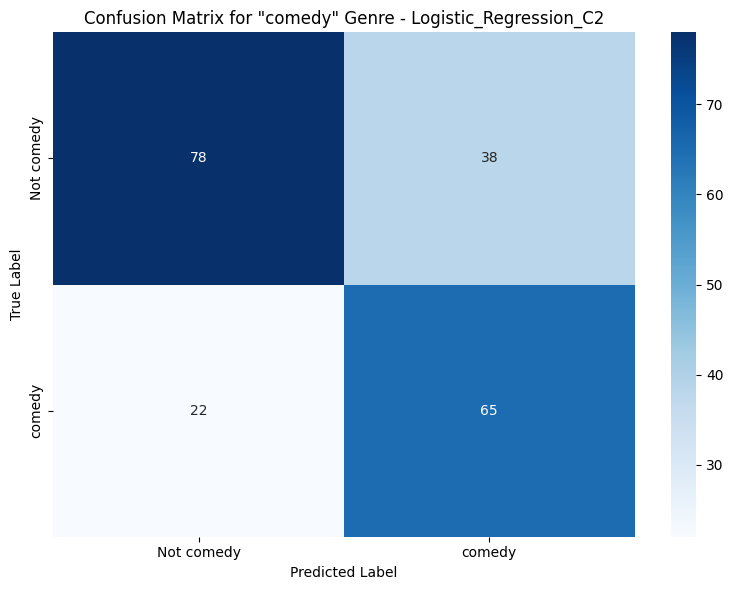

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


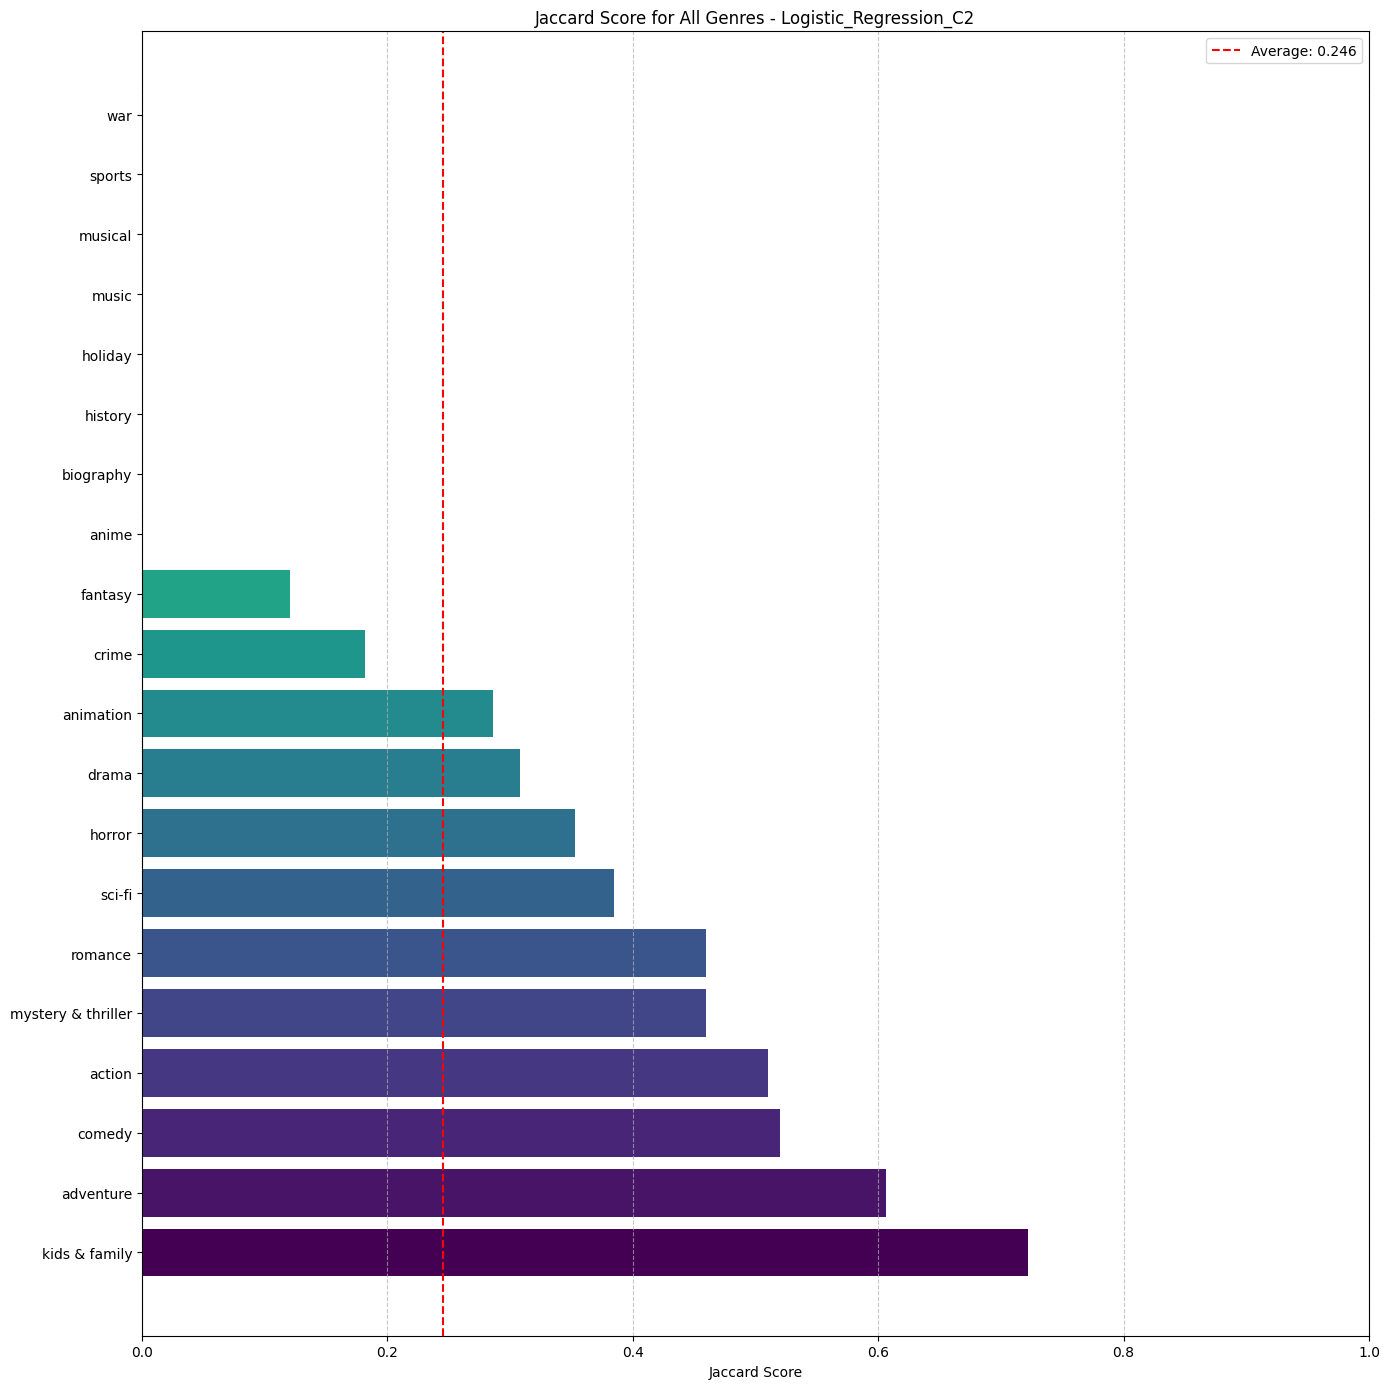

SVM Test Jaccard Score: 0.4463
SVM Test Hamming Loss: 0.1003
SVM Test Partial Accuracy (≥1 correct in 3): 0.9360

Classification Report for Top 5 Most Common Genres (SVM):

Genre: mystery & thriller
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       144
           1       0.49      0.85      0.62        59

    accuracy                           0.70       203
   macro avg       0.70      0.74      0.69       203
weighted avg       0.79      0.70      0.71       203


Genre: drama
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       144
           1       0.43      0.61      0.51        59

    accuracy                           0.66       203
   macro avg       0.62      0.64      0.62       203
weighted avg       0.70      0.66      0.67       203


Genre: action
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       129
         

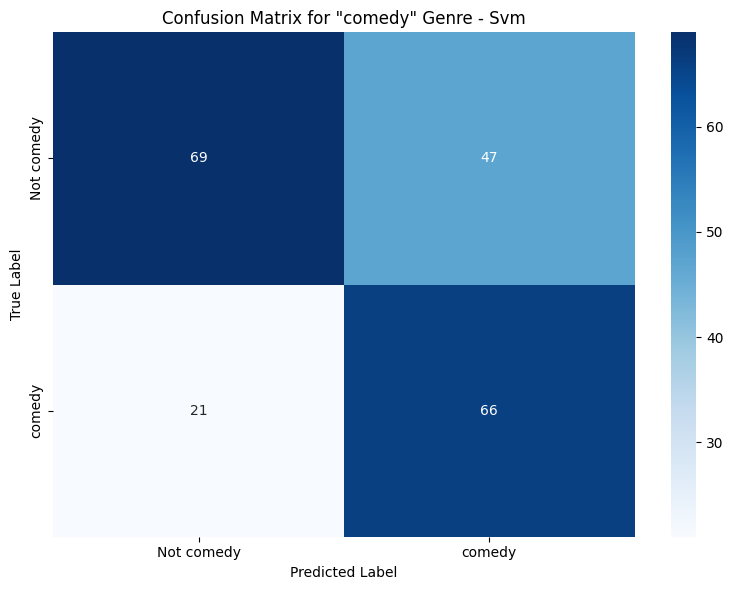

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


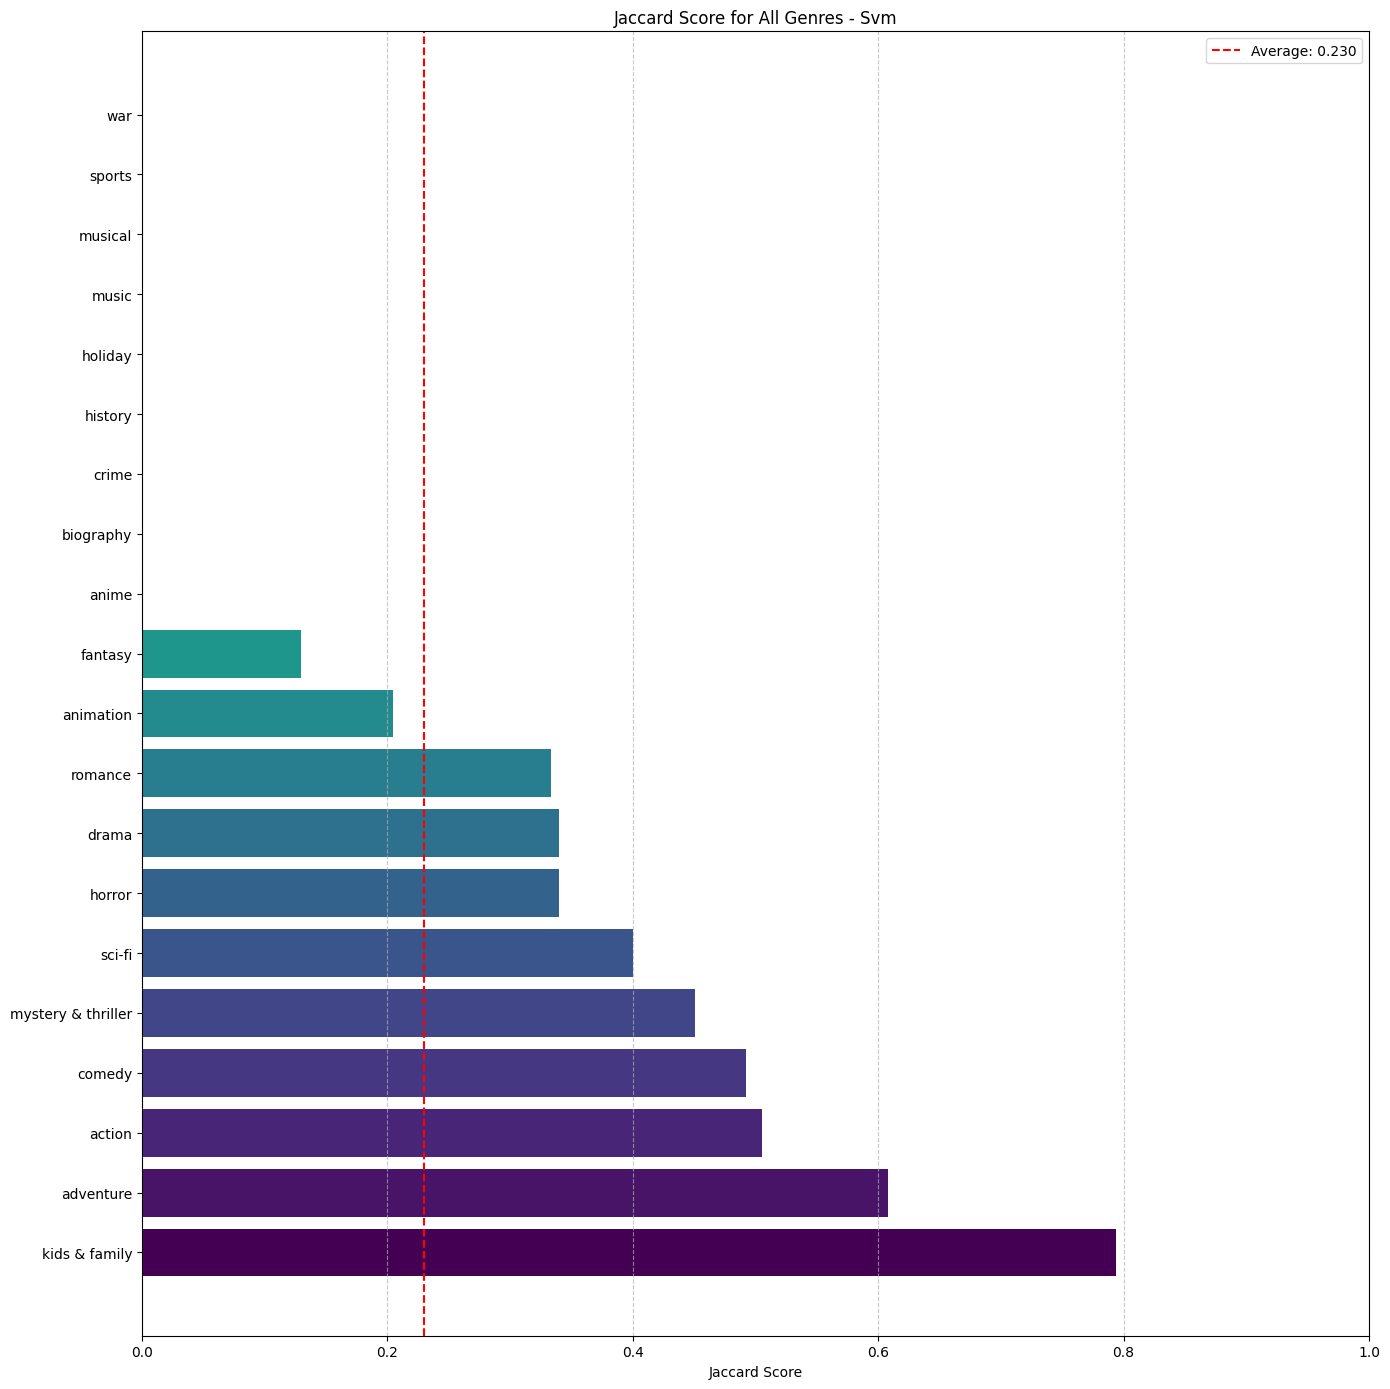

In [12]:
def evaluate_models(models, X_test, y_test, mlb):
    print("Evaluating models...")
    results = {}

    # List of genres to remove from visualization (if they exist)
    genres_to_exclude = ['western', 'sports & fitness', 'short', 'lgbtq+']

    for name, model_info in models.items():
        model = model_info['model']

        # Predict with adjusted threshold
        y_pred, y_probs = predict_with_adjusted_threshold(model, X_test, threshold=0.15)

        # Calculate metrics
        jaccard = jaccard_score(y_test, y_pred, average='samples')
        hamming = hamming_loss(y_test, y_pred)
        partial_acc = accuracy(y_test, y_pred)

        print(f"{name.upper()} Test Jaccard Score: {jaccard:.4f}")
        print(f"{name.upper()} Test Hamming Loss: {hamming:.4f}")
        print(f"{name.upper()} Test Partial Accuracy (≥1 correct in 3): {partial_acc:.4f}")

        # Display classification report for a few selected genres (top 5 most common)
        genre_counts = np.sum(y_test, axis=0)
        top_genre_indices = np.argsort(genre_counts)[-5:]

        print(f"\nClassification Report for Top 5 Most Common Genres ({name.upper()}):")
        for idx in top_genre_indices:
            genre_name = mlb.classes_[idx]
            print(f"\nGenre: {genre_name}")
            report = classification_report(y_test[:, idx], y_pred[:, idx])
            print(report)

        # Create and plot confusion matrix for a selected genre (most common genre)
        most_common_genre_idx = np.argmax(genre_counts)
        most_common_genre = mlb.classes_[most_common_genre_idx]

        cm = confusion_matrix(y_test[:, most_common_genre_idx], y_pred[:, most_common_genre_idx])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not ' + most_common_genre, most_common_genre],
                   yticklabels=['Not ' + most_common_genre, most_common_genre])
        plt.title(f'Confusion Matrix for "{most_common_genre}" Genre - {name.title()}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        plt.close()

        # Create performance by genre
        genre_performance = {}
        for i, genre in enumerate(mlb.classes_):
            genre_jaccard = jaccard_score(y_test[:, i], y_pred[:, i])
            # Only include the genre if it's not in the exclusion list
            if genre.lower() not in genres_to_exclude:
                genre_performance[genre] = genre_jaccard

        # Plot all genres by Jaccard score
        plt.figure(figsize=(14, 14))

        # Sort genres by performance
        sorted_genres = sorted(genre_performance.items(), key=lambda x: x[1], reverse=True)

        # All genres
        all_names = [g[0] for g in sorted_genres]
        all_scores = [g[1] for g in sorted_genres]

        # Calculate number of genres
        n_genres = len(all_names)

        # Create colormap based on score values
        colors = plt.cm.viridis(np.linspace(0, 1, n_genres))

        # Plot all genres
        plt.barh(all_names, all_scores, color=colors)
        plt.title(f'Jaccard Score for All Genres - {name.title()}')
        plt.xlabel('Jaccard Score')
        plt.xlim(0, 1)
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        # Add a vertical line for average Jaccard score
        avg_score = np.mean(all_scores)
        plt.axvline(x=avg_score, color='red', linestyle='--',
                   label=f'Average: {avg_score:.3f}')
        plt.legend()

        plt.tight_layout()
        plt.show()
        plt.close()

        results[name] = {
            'jaccard': jaccard,
            'hamming_loss': hamming,
            'partial_accuracy': partial_acc,
            'predictions': y_pred,
            'probabilities': y_probs,
            'genre_performance': genre_performance
        }

    return results

results = evaluate_models(models, X_test_reduced, y_test, mlb)

### Trực quan hóa kết quả và cho biết model có accuracy cao nhất

Visualizing results...


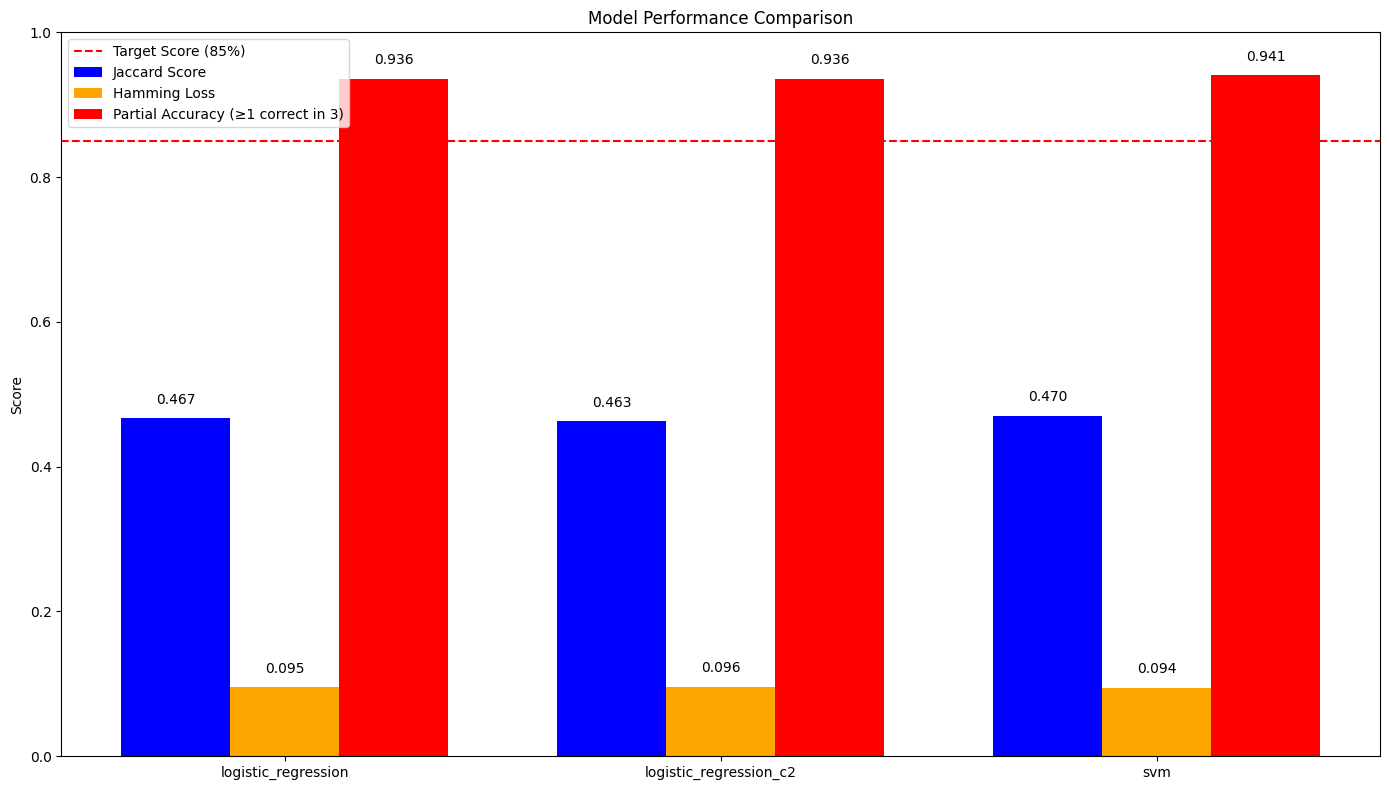

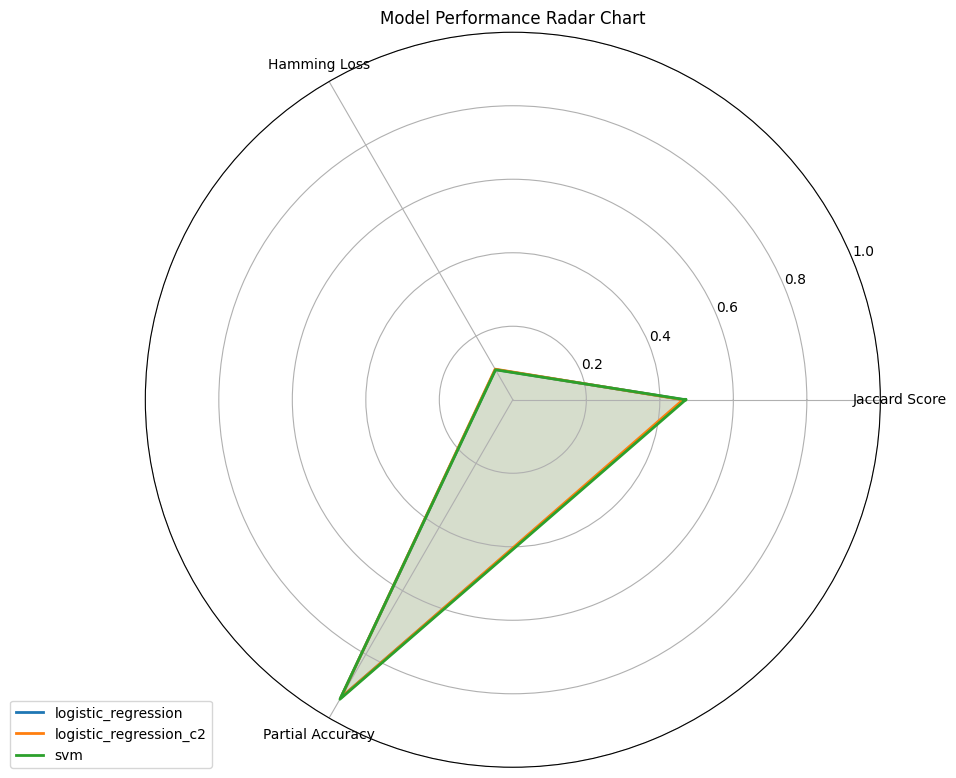


Best model based on Accuracy: SVM
Accuracy: 0.9409
Jaccard score: 0.4703
Hamming loss: 0.0942


In [ ]:
def visualize_results(models, X_test, y_test, mlb):
    print("Visualizing results...")
    # Get best model based on partial accuracy
    best_model_name = max(models, key=lambda k: models[k].get('partial_accuracy', 0))

    # Calculate metrics if missing
    for model_name, model_info in models.items():
        if 'partial_accuracy' not in model_info:
            print(f"Calculating metrics for {model_name} on the fly...")

            # Predict with adjusted threshold
            y_pred, y_probs = predict_with_adjusted_threshold(model_info['model'], X_test, threshold=0.15)

            # Calculate metrics
            model_info['partial_accuracy'] = accuracy(y_test, y_pred)
            model_info['probabilities'] = y_probs

    # Plot metrics comparison
    plt.figure(figsize=(14, 8))

    # Metrics for each model
    jaccard_scores = [models[model]['jaccard'] for model in models]
    hamming_scores = [models[model]['hamming_loss'] for model in models]
    partial_acc_scores = [models[model]['partial_accuracy'] for model in models]

    x = np.arange(len(models))
    width = 0.25

    plt.bar(x - width, jaccard_scores, width, color='blue', label='Jaccard Score')
    plt.bar(x, hamming_scores, width, color='orange', label='Hamming Loss')
    plt.bar(x + width, partial_acc_scores, width, color='red', label='Partial Accuracy (≥1 correct in 3)')

    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(x, models.keys())
    plt.axhline(y=0.85, color='r', linestyle='--', label='Target Score (85%)')
    plt.ylim(0, 1.0)

    # Add values on bars
    for i, v in enumerate(jaccard_scores):
        plt.text(i - width, v + 0.02, f'{v:.3f}', ha='center')

    for i, v in enumerate(hamming_scores):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

    for i, v in enumerate(partial_acc_scores):
        plt.text(i + width, v + 0.02, f'{v:.3f}', ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

    # Create a radar chart to compare model performance across multiple metrics
    plt.figure(figsize=(10, 8))

    # Define metrics to compare
    metrics = ['Jaccard Score', 'Hamming Loss', 'Partial Accuracy']

    # Number of metrics
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Radar chart plot
    ax = plt.subplot(111, polar=True)

    # For each model
    for i, model_name in enumerate(models.keys()):
        model = models[model_name]

        # Get metric values
        values = [
            model['jaccard'],
            model['hamming_loss'],
            model['partial_accuracy']
        ]
        values += values[:1]  # Close the loop

        # Plot model values
        ax.plot(angles, values, linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.1)

    # Set labels
    plt.xticks(angles[:-1], metrics)

    # Y axis limits
    plt.ylim(0, 1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title('Model Performance Radar Chart')
    plt.tight_layout()
    plt.show()
    plt.close()

visualize_results(models, X_test_reduced, y_test, mlb)
best_model = max(models, key=lambda k: models[k].get('partial_accuracy', 0))
print(f"\nBest model based on Accuracy: {best_model.upper()}")
print(f"Accuracy: {models[best_model]['partial_accuracy']:.4f}")
print(f"Jaccard score: {models[best_model]['jaccard']:.4f}")
print(f"Hamming loss: {models[best_model]['hamming_loss']:.4f}")


### Kiểm thử dự đoán

In [ ]:
def predict_genre(title, description, rating, models, tfidf, le, svd, scaler, mlb, model_choice=None):
    """
    Predict genres using traditional ML models
    """
    # List of genres to exclude from results
    genres_to_exclude = ['western', 'sports & fitness', 'short', 'lgbtq+']

    # Process input
    description = description.lower()
    description_tfidf = tfidf.transform([description])

    try:
        rating_encoded = le.transform([rating]).reshape(-1, 1)
    except:
        print(f"Warning: Rating '{rating}' not seen during training. Using most common rating instead.")
        rating_encoded = np.array([[0]])  # Default to first class

    # Combine features
    X_input = np.hstack((description_tfidf.toarray(), rating_encoded))

    # Reduce dimensions and scale
    X_input_reduced = svd.transform(X_input)
    X_input_scaled = scaler.transform(X_input_reduced)

    # Select model based on user choice or default to best model
    if model_choice and model_choice in models:
        chosen_model = models[model_choice]['model']
        model_name = model_choice
    else:
        # Default to best model based on partial accuracy
        model_name = max(models, key=lambda k: models[k].get('partial_accuracy', 0))
        chosen_model = models[model_name]['model']

    print(f"Using {model_name.upper()} model for prediction")

    # Get probabilities for all genres
    probs = []
    for estimator in chosen_model.estimators_:
        if hasattr(estimator, 'predict_proba'):
            probs.append(estimator.predict_proba(X_input_scaled)[0][1])

    probs = np.array(probs)

    # Filter out excluded genres from results
    valid_indices = [i for i, genre in enumerate(mlb.classes_) if genre.lower() not in genres_to_exclude]

    # Get top 3 genres with highest probabilities from valid genres
    valid_probs = probs[valid_indices]
    valid_indices_sorted = np.argsort(valid_probs)[::-1]
    top3_indices = [valid_indices[i] for i in valid_indices_sorted[:3]]
    predicted_genres = mlb.classes_[top3_indices]

    # Convert to (genre, probability) pairs for all valid genres
    genre_probs = [(mlb.classes_[i], probs[i]) for i in valid_indices]

    # Sort by probability
    genre_probs.sort(key=lambda x: x[1], reverse=True)

    result = {
        'title': title,
        'predicted_genres': predicted_genres,
        'top_genres': genre_probs[:3],  # Top 3 genres with probabilities
        'model_used': model_name,
        'partial_accuracy': models[model_name]['partial_accuracy']
    }

    return result

def test_prediction(models, tfidf, le, svd, scaler, mlb, model_name=None):
    print("Testing prediction...")
    print("\n" + "="*50)
    print("Genre Prediction System")
    print("="*50)
    best_model = max(models, key=lambda k: models[k].get('partial_accuracy', 0))
    print(f"\nBest model: {best_model.upper()}")
    print(f"Accuracy: {models[best_model]['partial_accuracy']:.4f}")
    print(f"Jaccard score: {models[best_model]['jaccard']:.4f}")
    print(f"Hamming loss: {models[best_model]['hamming_loss']:.4f}")
    while True:
        print("\nEnter movie details (or 'exit' to quit):")
        title = input("Title: ")
        if title.lower() == 'exit':
            break

        description = input("Description: ")
        rating = input("Rating (e.g., PG, PG-13, R): ")

        # Let user choose model
        print("\nChoose a model for prediction:")
        print("1. Logistic Regression (C=1.0)")
        print("2. Logistic Regression (C=2.0)")
        print("3. SVM")
        print("4. Best model (based on Accuracy)")

        model_choice = input(f"Enter choice (1-4): ")

        if model_choice == '1':
            model_name = 'logistic_regression'
        elif model_choice == '2':
            model_name = 'logistic_regression_c2'
        elif model_choice == '3':
            model_name = 'svm'
        else:
            model_name = None  # Will use best model based on partial accuracy

        result = predict_genre(title, description, rating, models, tfidf, le, svd, scaler, mlb, model_name)

        print("\nPrediction Result:")
        print(f"Movie: {result['title']}")
        print(f"Model used: {result['model_used'].upper()}")
        print(f"Model's Accuracy: {result['partial_accuracy']:.4f}")

        print("\nPredicted Genres (Top 3):")
        for genre in result['predicted_genres']:
            print(f"  {genre}")

        print("\nGenres with Probabilities:")
        for genre, prob in result['top_genres']:
            prob_percent = prob * 100
            stars = "*" * int(prob_percent / 10)
            print(f"  {genre}: {prob_percent:.2f}% {stars}")

        print("\n" + "-"*50)

test_prediction(models, tfidf, le, svd, scaler, mlb)

Testing prediction...

Genre Prediction System

Best model: SVM
Accuracy: 0.9409
Jaccard score: 0.4703
Hamming loss: 0.0942

Enter movie details (or 'exit' to quit):
Title: A Minecraft Movie
Description: Welcome to the world of Minecraft, where creativity doesn't just help you craft, it's essential to one's survival! Four misfits--Garrett "The Garbage Man" Garrison (Jason Momoa), Henry (Sebastian Eugene Hansen), Natalie (Emma Myers) and Dawn (Danielle Brooks)--find themselves struggling with ordinary problems when they are suddenly pulled through a mysterious portal into the Overworld: a bizarre, cubic wonderland that thrives on imagination. To get back home, they'll have to master this world (and protect it from evil things like Piglins and Zombies, too) while embarking on a magical quest with an unexpected, expert crafter, Steve (Jack Black). Together, their adventure will challenge all five to be bold and to reconnect with the qualities that make each of them uniquely creative... th